# Import

In [6]:
import pandas as pd
import numpy as np
import os, time,json
import tmdbsimple as tmdb 
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

## Using Your API Credentials

In [7]:
# Load API Credentials
import json
with open('/Users/Ernesto/.secret/tmdb_api.json') as f:
    login = json.load(f)

In [8]:
# display keys
login.keys()

dict_keys(['client-id', 'api-key'])

In [9]:
tmdb.API_KEY = login['api-key']

## Designate a folder

In [10]:
# create a new folder
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['title_akas.csv.gz', 'title_basics.csv.gz', 'title_ratings.csv.gz']

## Defining Our Function

In [15]:
def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [16]:
def get_movie_with_rating(movie_id):
    # get the movie object for the currend id
    movie = tmdb.Movies(movie_id)
    #save the .info .releases dictionaries
    info = movie.info()
    
    releases = movie.releases()
    # loop thrpoght countries in releases
    for c in releases['countries']:
        # if the country abbreviation == US
        if c['iso_3166_1'] =='US':
            # save a certificatiion key in info with the certification
            info['certification'] = c['certification']
    return info

In [13]:
# test function to confirm my API is working
test = get_movie_with_rating('tt0332280')
test

{'adult': False,
 'backdrop_path': '/qom1SZSENdmHFNZBXbtJAU0WTlC.jpg',
 'belongs_to_collection': None,
 'budget': 29000000,
 'genres': [{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}],
 'homepage': 'http://www.newline.com/properties/notebookthe.html',
 'id': 11036,
 'imdb_id': 'tt0332280',
 'original_language': 'en',
 'original_title': 'The Notebook',
 'overview': "An epic love story centered around an older man who reads aloud to a woman with Alzheimer's. From a faded notebook, the old man's words bring to life the story about a couple who is separated by World War II, and is then passionately reunited, seven years later, after they have taken different paths.",
 'popularity': 59.477,
 'poster_path': '/rNzQyW4f8B8cQeg7Dgj3n6eT5k9.jpg',
 'production_companies': [{'id': 12,
   'logo_path': '/iaYpEp3LQmb8AfAtmTvpqd4149c.png',
   'name': 'New Line Cinema',
   'origin_country': 'US'},
  {'id': 1565, 'logo_path': None, 'name': 'Avery Pix', 'origin_country': 'US'},
  {'id': 26

## requested you perform a test extraction of movies that started in 2000 or 2001

In [19]:
YEARS_TO_GET = [2000,2001]

## Define an errors list

In [20]:
errors = [ ]

## OUTER and INNER loop

In [22]:
# Open saved file and preview again
basics = pd.read_csv("Data/title_basics.csv.gz", low_memory = False)
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002,NaN,126,Drama


In [23]:
# Start of OUTER loop ( Iterate through years 2000 and 2001)

for YEAR in tqdm_notebook(YEARS_TO_GET,desc='YEARS',position=0):
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # Check if JSON file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
            
    #Define/filter the IDs to call( From Basics dataset filter out movie ids for the year (2000 & 2001)
    #Saving new year as the current df
    df = basics.loc[ basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    # Load existing data from json into a dataframe called "previous_df"
    
    previous_df = pd.read_json(JSON_FILE)
    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    
    # Start of INNER LOOP
    # Iterate through the list of Movies IDs and make the calls
        #Get index and movie id from list
    
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve then data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            
        except Exception as e:
            errors.append([movie_id, e])
            
    # Save your results as csv.gz file
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2000:   0%|          | 0/1421 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/1533 [00:00<?, ?it/s]

In [24]:
# Print a message reporting back the number of movie ids that caused an error.
print(f"- Total errors: {len(errors)}")

- Total errors: 449


## open  csv.gz file

In [25]:
# year = 2000
df_2000 = pd.read_csv('Data/final_tmdb_data_2000.csv.gz', low_memory = False)
df_2000

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.1,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.0,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.1,2070.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,tt6174238,0.0,NaN,NaN,0.0,"[{'id': 80, 'name': 'Crime'}]",NaN,223878.0,cn,冷战,...,0.0,0.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,Cold War,0.0,2.0,2.0,NaN
1211,tt7029820,0.0,NaN,NaN,7000.0,[],NaN,604889.0,en,Scream For Christmas,...,0.0,80.0,[],Released,NaN,Scream For Christmas,0.0,0.0,0.0,NaN
1212,tt7197642,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,872676.0,en,"Goodbye, Merry-Go-Round",...,0.0,90.0,[],Released,NaN,"Goodbye, Merry-Go-Round",0.0,0.0,0.0,NaN
1213,tt7631368,0.0,/sF0gUHE0YzZNXYugTB2LFxJIppf.jpg,NaN,10000000.0,"[{'id': 27, 'name': 'Horror'}]",NaN,97186.0,fr,"I, Vampire",...,0.0,85.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,"I, Vampire",0.0,6.4,4.0,NR


In [26]:
# year = 2001
df_2001 = pd.read_csv('Data/final_tmdb_data_2001.csv.gz', low_memory = False)
df_2001

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,...,76019048.0,118.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.322,1163.0,PG-13
2,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.000,3.0,NaN
3,tt0118589,0.0,/9NZAirJahVilTiDNCHLFcdkwkiy.jpg,NaN,22000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,10696.0,en,Glitter,...,5271666.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"In music she found her dream, her love, herself.",Glitter,0.0,4.601,119.0,PG-13
4,tt0118652,0.0,/mWxJEFRMvkG4UItYJkRDMgWQ08Y.jpg,NaN,1000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",NaN,17140.0,en,The Attic Expeditions,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,His search for peace of mind... will leave his...,The Attic Expeditions,0.0,5.100,28.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,tt7797670,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,956214.0,en,Edmund Kemper Part 2: La Mort C'est La Vie,...,0.0,91.0,[],Released,NaN,Edmund Kemper Part 2: La Mort C'est La Vie,0.0,0.000,0.0,NaN
1288,tt7797790,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,956219.0,en,Edmund Kemper Part 3: La mort sévit,...,0.0,72.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,NaN,Edmund Kemper Part 3: La mort sévit,0.0,0.000,0.0,NaN
1289,tt8665056,0.0,NaN,NaN,0.0,"[{'id': 37, 'name': 'Western'}]",http://skeletoncreekproductions.com/p-movie-br...,885436.0,en,Guns Along The Bravo,...,0.0,85.0,[],Released,Evil came to the Southwest until three blazing...,Guns Along The Bravo,0.0,0.000,0.0,NaN
1290,tt8795764,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",https://www.utahwolf.com/films/coming-soon-new...,871624.0,en,New Breed,...,0.0,57.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,New Breed,0.0,0.000,0.0,NR


## Concatenate the data into 1 dataframe for the remainder of the analysis.

In [27]:
df_2000_2001 = pd.concat([df_2000, df_2001], axis=0)
df_2000_2001

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.1,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.0,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.1,2070.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,tt7797670,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,956214.0,en,Edmund Kemper Part 2: La Mort C'est La Vie,...,0.0,91.0,[],Released,NaN,Edmund Kemper Part 2: La Mort C'est La Vie,0.0,0.0,0.0,NaN
1288,tt7797790,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,956219.0,en,Edmund Kemper Part 3: La mort sévit,...,0.0,72.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,NaN,Edmund Kemper Part 3: La mort sévit,0.0,0.0,0.0,NaN
1289,tt8665056,0.0,NaN,NaN,0.0,"[{'id': 37, 'name': 'Western'}]",http://skeletoncreekproductions.com/p-movie-br...,885436.0,en,Guns Along The Bravo,...,0.0,85.0,[],Released,Evil came to the Southwest until three blazing...,Guns Along The Bravo,0.0,0.0,0.0,NaN
1290,tt8795764,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",https://www.utahwolf.com/films/coming-soon-new...,871624.0,en,New Breed,...,0.0,57.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,New Breed,0.0,0.0,0.0,NR


## EDA

1 - How many movies had at least some valid financial information (values > 0 for budget OR revenue)?

Please exclude any movies with 0's for budget AND revenue from the remaining visualizations.

In [28]:
valid_finalcial = df_2000_2001[(df_2000_2001['budget'] != 0) | (df_2000_2001['revenue'] != 0)]
print(f'{len(valid_finalcial)} movies had at least some valid financial information')

628 movies had at least some valid financial information


In [29]:
unvalid_financial = df_2000_2001[(df_2000_2001['budget'] == 0) & (df_2000_2001['revenue'] == 0)]
print(f'There are {len(unvalid_financial)} movies with 0 for budget AND revenue')

There are 1879 movies with 0 for budget AND revenue


In [30]:
# Please exclude any movies with 0's for budget AND revenue from the remaining visualizations
valid_finalcial

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.100,2070.0,PG
6,tt0119273,0.0,/f5C03doOWiauu37bToKXtpgP5bS.jpg,"{'id': 141086, 'name': 'Heavy Metal Collection...",15000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,16225.0,en,Heavy Metal 2000,...,0.0,88.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,not to survive the fight in the external world...,Heavy Metal 2000,0.0,6.073,170.0,R
10,tt0120263,0.0,/ynXVuylP8upazjz8lrqb1PEMkdR.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,34070.0,sv,Sånger från andra våningen,...,80334.0,98.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",Released,NaN,Songs from the Second Floor,0.0,7.218,225.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,tt0445841,0.0,/lO3XAxV38SC7ZuuNVdy6E6nOZac.jpg,NaN,12500000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,233308.0,zh,一個爛賭的傳說,...,123021750.0,94.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,A Gambler's Story,0.0,6.800,3.0,NaN
1245,tt0867181,0.0,NaN,NaN,5000.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,749151.0,en,Patient,...,0.0,88.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Only a miracle can save Sean now,Patient,0.0,0.000,0.0,NaN
1247,tt1039952,0.0,/yTGmGjAd0gfpVK0ezoqWgx7AJkp.jpg,NaN,500000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,69399.0,ta,சிட்டிசன்,...,500000.0,157.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Citizen,0.0,6.679,14.0,NaN
1259,tt1764172,0.0,NaN,NaN,250000.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,228977.0,en,Among Thieves,...,0.0,0.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Among Thieves,0.0,0.000,0.0,NaN


In [31]:
# check nan values in new dataframe 
valid_finalcial.isna().sum()

imdb_id                    0
adult                      2
backdrop_path             98
belongs_to_collection    525
budget                     2
genres                     2
homepage                 551
id                         2
original_language          2
original_title             2
overview                   5
popularity                 2
poster_path               24
production_companies       2
production_countries       2
release_date               2
revenue                    2
runtime                    2
spoken_languages           2
status                     2
tagline                  140
title                      2
video                      2
vote_average               2
vote_count                 2
certification            201
dtype: int64

## 2 - How many movies are there in each of the certification categories (G/PG/PG-13/R)?

In [32]:
nan_certification = valid_finalcial['certification'].isna().sum()
print(f'there are {nan_certification} movies with missing certification')

there are 201 movies with missing certification


In [33]:
# replace nan per unknow
valid_finalcial['certification'] = valid_finalcial['certification'].fillna('unknow')

C:\Users\Ernesto\AppData\Local\Temp\ipykernel_18140\3302353660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_finalcial['certification'] = valid_finalcial['certification'].fillna('unknow')


In [34]:
# check missing values again
nan_certification = valid_finalcial['certification'].isna().sum()
print(f'there are {nan_certification} movies with missing certification')
import warnings
warnings.filterwarnings('ignore')

there are 0 movies with missing certification


In [35]:
valid_finalcial['certification'].value_counts()

R         229
unknow    201
PG-13     131
PG         36
NR         17
G          14
Name: certification, dtype: int64

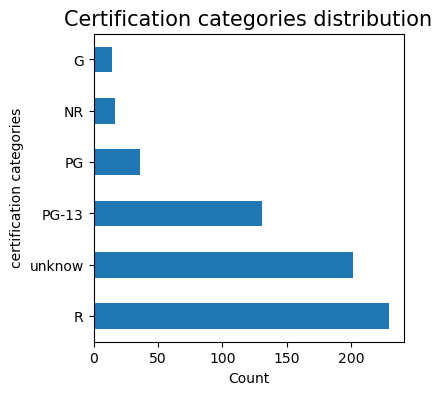

In [36]:
types = valid_finalcial['certification'].value_counts()
types.plot(kind='barh', figsize=(4,4))
plt.ylabel('certification categories', fontsize=10)

plt.xlabel('Count', fontsize=10)
plt.title('Certification categories distribution', fontsize=15)
plt.show()

## 3 - What is the average revenue per certification category?

In [37]:
aveg_renue = valid_finalcial.groupby('certification')['revenue'].mean()
aveg_renue

certification
G         1.237463e+08
NR        8.887611e+06
PG        1.095204e+08
PG-13     9.926299e+07
R         3.321119e+07
unknow    7.968370e+06
Name: revenue, dtype: float64

In [38]:
aveg_renue = valid_finalcial.groupby('certification')['revenue']

In [39]:
aveg_renue_sorted = valid_finalcial.groupby('certification')['revenue'].mean().reset_index().sort_values('revenue')

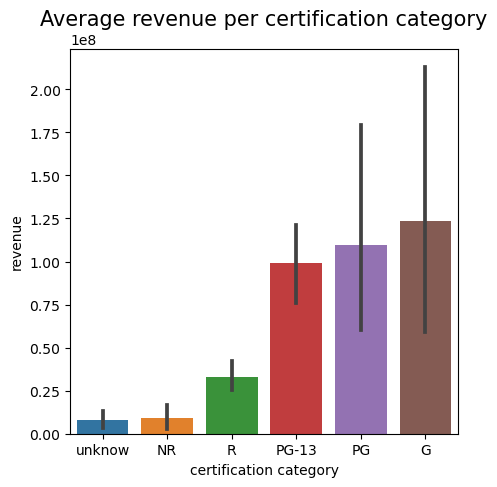

In [40]:
plt.figure(figsize=(5,5))
sns.barplot(data=valid_finalcial, x='certification', y='revenue', order= aveg_renue_sorted['certification'])
plt.title('Average revenue per certification category', fontsize=15)
plt.xlabel('certification category', fontsize=10)
plt.ylabel('revenue', fontsize=10)
plt.show()

## 4 - What is the average budget per certification category?

In [41]:
aveg_budget = valid_finalcial.groupby('certification')['budget'].mean()
aveg_budget

certification
G         4.085714e+07
NR        6.302358e+06
PG        4.392361e+07
PG-13     4.315388e+07
R         1.974674e+07
unknow    4.412001e+06
Name: budget, dtype: float64

In [42]:
aveg_budget_sorted = valid_finalcial.groupby('certification')['budget'].mean().reset_index().sort_values('budget')

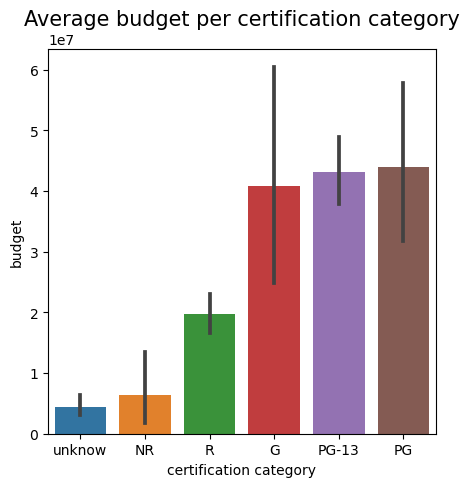

In [43]:
plt.figure(figsize=(5,5))
sns.barplot(data=valid_finalcial, x='certification', y='budget', order= aveg_budget_sorted['certification'])
plt.title('Average budget per certification category', fontsize=15)
plt.xlabel('certification category', fontsize=10)
plt.ylabel('budget', fontsize=10)
plt.show()